[View in Colaboratory](https://colab.research.google.com/github/jeness/BPlusTree/blob/master/Copy_of_TF_Hub_Delf_module.ipynb)

##Get CPU and GPU info

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm pti fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) 

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10244147713455058569, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11280557671
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 171532122458545845
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# How to match images using DELF and TensorFlow Hub

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf_hub_delf_module.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_delf_module.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>



TensorFlow Hub (TF-Hub) is a platform to share machine learning expertise packaged in reusable resources, notably pre-trained **modules**.

In this colab, we will use a module that packages the [DELF](https://github.com/tensorflow/models/tree/master/research/delf) neural network and logic for processing images to identify keypoints and their descriptors. The weights of the neural network were trained on images of landmarks as described in [this paper](https://arxiv.org/abs/1612.06321).

In [0]:
#@title Update the versions of TF and TF-Hub, if needed.

!pip install -q 'tensorflow>=1.7'
!pip install -q 'tensorflow-hub>=0.1.0'
!pip install -q 'scikit-image'

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

## The data

In the next cell, we specify the URLs of two images we would like to process with DELF in order to match and compare them.

In [0]:
IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/2/28/Bridge_of_Sighs%2C_Oxford.jpg'
IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/c3/The_Bridge_of_Sighs_and_Sheldonian_Theatre%2C_Oxford.jpg'

IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/1/1e/Golden_gate2.jpg'
IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/3/3e/GoldenGateBridge.jpg'

IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/ce/2006_01_21_Ath%C3%A8nes_Parth%C3%A9non.JPG'
IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/5/5c/ACROPOLIS_1969_-_panoramio_-_jean_melis.jpg'

# IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/d/d8/Eiffel_Tower%2C_November_15%2C_2011.jpg'
# IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/a/a8/Eiffel_Tower_from_immediately_beside_it%2C_Paris_May_2008.jpg'

# IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/2/2d/Parthenon-Restoration-Nov-2005-a.jpg'
# IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/5/57/White_House_06.02.08.jpg'

Download, resize, save and display the images.

In [0]:
# The names that will be used for the resized local images.

IMAGE_1_JPG = 'image_1.jpg'
IMAGE_2_JPG = 'image_2.jpg'

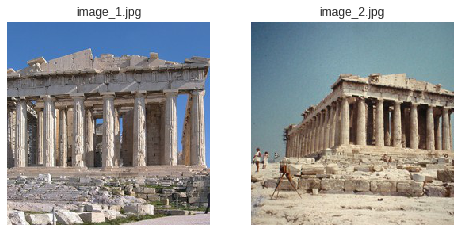

In [0]:
#@title The images that will be processed by DELF
def download_and_resize_image(url, filename, new_width=256, new_height=256):
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename, format='JPEG', quality=90)

download_and_resize_image(IMAGE_1_URL, IMAGE_1_JPG)
download_and_resize_image(IMAGE_2_URL, IMAGE_2_JPG)

def show_images(image_path_list):
  plt.figure()
  for i, image_path in enumerate(image_path_list):
    plt.subplot(1, len(image_path_list), i+1)
    plt.imshow(np.asarray(Image.open(image_path)))
    plt.title(image_path)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
  plt.show()

show_images([IMAGE_1_JPG, IMAGE_2_JPG])

Next, we define a function to read the images into a tensor so that they can be processed by TensorFlow.

In [0]:
def image_input_fn():
  filename_queue = tf.train.string_input_producer(
      [IMAGE_1_JPG, IMAGE_2_JPG], shuffle=False)
  reader = tf.WholeFileReader()
  _, value = reader.read(filename_queue)
  image_tf = tf.image.decode_jpeg(value, channels=3)
  return tf.image.convert_image_dtype(image_tf, tf.float32)

## Apply the DELF module to the data

The DELF module takes an image as input and will describe noteworthy points with vectors. The following cell contains the core of this colab's logic.

In [0]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn()

with tf.train.MonitoredSession() as sess:
  results_dict = {}  # Stores the locations and their descriptors for each image
  for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
    image = sess.run(image_tf)
    print('Extracting locations and descriptors from %s' % image_path)
    results_dict[image_path] = sess.run(
        [module_outputs['locations'], module_outputs['descriptors']],
        feed_dict={image_placeholder: image})

Extracting locations and descriptors from image_1.jpg
Extracting locations and descriptors from image_2.jpg


## Use the locations and description vectors to match the images

Loaded image 1's 279 features
Loaded image 2's 170 features


/usr/local/lib/python2.7/dist-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/usr/local/lib/python2.7/dist-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


Found 38 inliers


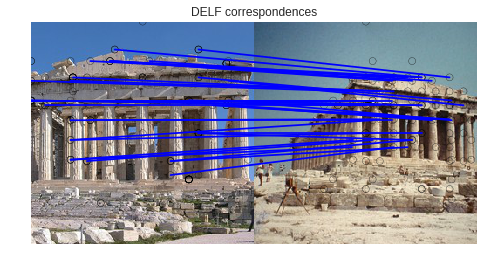

In [0]:
#@title TensorFlow is not needed for this post-processing and visualization
def match_images(results_dict, image_1_path, image_2_path):
  distance_threshold = 0.8

  # Read features.
  locations_1, descriptors_1 = results_dict[image_1_path]
  num_features_1 = locations_1.shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  locations_2, descriptors_2 = results_dict[image_2_path]
  num_features_2 = locations_2.shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(descriptors_1)
  _, indices = d1_tree.query(
      descriptors_2, distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      locations_2[i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      locations_1[indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots()
  img_1 = mpimg.imread(image_1_path)
  img_2 = mpimg.imread(image_2_path)
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      img_1,
      img_2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')

match_images(results_dict, IMAGE_1_JPG, IMAGE_2_JPG)
